<a href="https://colab.research.google.com/github/CoiferousYogi/Audio-Analysis-and-Spectrography/blob/main/Spectrogram_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa
import librosa

audio_path = "/content/sample-15s.wav"
y,sr = librosa.load(audio_path, sr = 22050)


In [ ]:
# chunking the audio
import numpy as np
chunk_duration = 10
samples_per_chunk = int(chunk_duration * sr)
chunks = [y[i:i+samples_per_chunk] for i in range(0, len(y), samples_per_chunk)]

In [ ]:
# applying hamming window function to reduce spectral leakage
!pip install scipy
from scipy import signal

def apply_hamming(chunk):
  window = signal.windows.hamming(len(chunk))
  return chunk * window

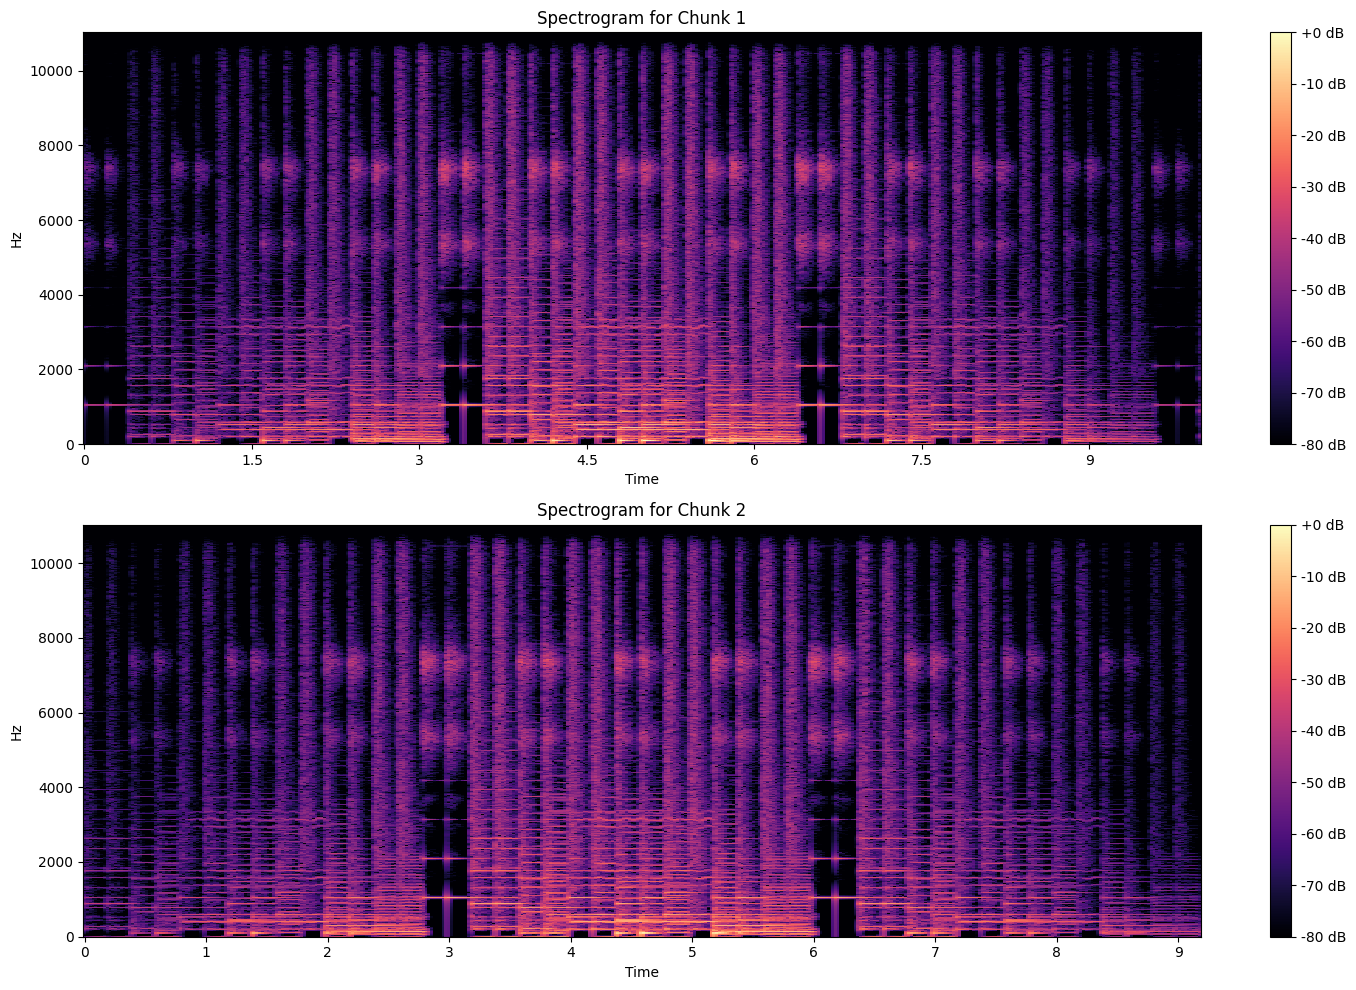

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

def get_spectrogram(chunk, sr):
    chunk = apply_hamming(chunk)
    D = librosa.stft(chunk, n_fft=2048, hop_length=512)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return S_db

# Plot all chunks in subplots
n = len(chunks)
plt.figure(figsize=(15, 5 * n))

for i, chunk in enumerate(chunks):
    plt.subplot(n, 1, i + 1)
    S_db = get_spectrogram(chunk, sr)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f'Spectrogram for Chunk {i+1}')

plt.tight_layout()
plt.show()


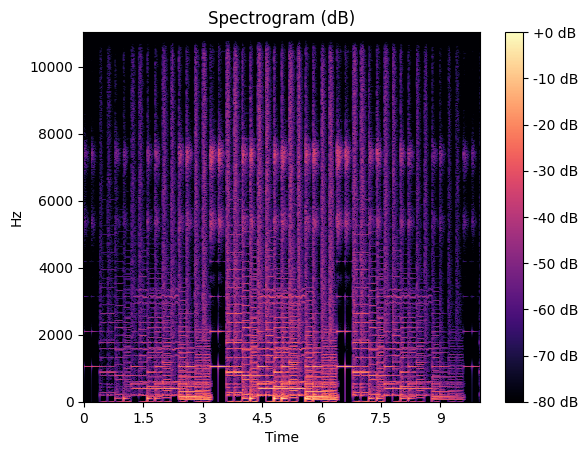

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

def get_spectrogram(chunk, sr):
    # Apply Hamming
    chunk = apply_hamming(chunk)

    # STFT returns a complex-valued matrix
    D = librosa.stft(chunk, n_fft=2048, hop_length=512)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    return D, S_db

# Example:
D, S_db = get_spectrogram(chunks[0], sr)

# Visualize
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format="%+2.0f dB")
plt.title('Spectrogram (dB)')
plt.show()


In [ ]:
# Now we will try to extract the spectral peaks
!pip install scipy scikit-image
import numpy as np
from skimage.feature import peak_local_max

def extract_peaks(S_db, threshold_db=-30, min_distance=20):
  mask = S_db > threshold_db
  coordinates = peak_local_max(S_db, min_distance=min_distance, threshold_abs=threshold_db, labels=mask)

  # convert the coordinates to a list of (frequency, time) tuples
  peaks = [tuple(coord) for coord in coordinates]

  return peaks

In [ ]:
def generate_fingerprints(peaks, fan_out=7):
    fingerprints = []
    peaks = sorted(peaks, key=lambda x: x[1])

    for i in range(len(peaks)):
        f1, t1 = peaks[i]
        for j in range(1, fan_out+1):
            if i + j < len(peaks):
                f2, t2 = peaks[i + j]
                delta_t = t2 - t1
                if 0 < delta_t <= 200:
                    hash_val = (f1, f2, delta_t)
                    fingerprints.append((hash_val, t1))
    return fingerprints


In [ ]:
chunk = chunks[0]  # use one chunk for now
D, S_db = get_spectrogram(chunks[0], sr)
peaks = extract_peaks(S_db)
fingerprints = generate_fingerprints(peaks)

# Example output
for h, t in fingerprints[:10]:
    print(f"Hash: {h}, Time: {t}")

Hash: (np.int64(73), np.int64(41), np.int64(36)), Time: 36
Hash: (np.int64(73), np.int64(49), np.int64(69)), Time: 36
Hash: (np.int64(73), np.int64(27), np.int64(69)), Time: 36
Hash: (np.int64(73), np.int64(97), np.int64(78)), Time: 36
Hash: (np.int64(73), np.int64(194), np.int64(103)), Time: 36
Hash: (np.int64(73), np.int64(685), np.int64(111)), Time: 36
Hash: (np.int64(73), np.int64(97), np.int64(112)), Time: 36
Hash: (np.int64(41), np.int64(49), np.int64(33)), Time: 72
Hash: (np.int64(41), np.int64(27), np.int64(33)), Time: 72
Hash: (np.int64(41), np.int64(97), np.int64(42)), Time: 72


In [ ]:
from collections import defaultdict

fingerprint_db = defaultdict(list)

def store_fingerprints(song_id, fingerprints):
  for h, t in fingerprints:
    fingerprint_db[h].append((song_id, t))

store_fingerprints("song_001", fingerprints)

In [ ]:
from collections import Counter

def match_fingerprints(query_fingerprints, database):
  match_counter = Counter()

  for h, t_query in query_fingerprints:
    if h in database:
      for song_id, t_db in database[h]:
        time_delta = t_db - t_query
        time_delta = t_db - t_query
        match_counter[(song_id, time_delta)] += 1

  return match_counter

In [ ]:
def identify_song(match_counter):
    if not match_counter:
        return None, 0

    # Find the (song_id, delta) pair with max matches
    ((best_song_id, _), score) = match_counter.most_common(1)[0]
    return best_song_id, score


In [ ]:
# STEP 1: Fingerprint your database songs
store_fingerprints("song_001", generate_fingerprints(extract_peaks(get_spectrogram(chunks[0], sr)[1])))

# STEP 2: Simulate a query using a part of the same song (or another song)
query_chunk = chunks[0][:sr * 5]  # 5 seconds
_, S_db_query = get_spectrogram(query_chunk, sr)
query_peaks = extract_peaks(S_db_query)
query_fps = generate_fingerprints(query_peaks)

# STEP 3: Match and identify
matches = match_fingerprints(query_fps, fingerprint_db)
best_match, confidence = identify_song(matches)

print(f"Best match: {best_match}, confidence (match count): {confidence}")


Best match: song_001, confidence (match count): 28
